<a href="https://colab.research.google.com/github/rvalienter90/UCF/blob/master/CAP-5610_MACHINE%20LEARNING/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RODOLFO VALIENTE ROMERO**



# HW 3

** *Code is based on course notes and was used code from the Colab examples**

The goal of this homework is to learn how to leverage pretrained convnets and to use some visualization techniques.
You will work with the data set *cats vs dogs* and use the pretrained convnet VGG19.

Experiment with different classifiers, trying to maximize the validation accuracy. You only need to show one classifier.

---
**Problem 1**

Do feature extraction with data augmentation.

**Problem 2**

Do fine-tuning with data augmentation. 

**Problem 3**

Visualize heatmaps of class activation for the the model obtained in Problem 2.

**Problem 4**

Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.


** FINAL SOLUTIONS**

1.    ** Run the section   Loading the image  dataset and functions **
2.    ** Run the Problem x Final Sollution **

 **Extra exploration is done in the other sections **

## Loading the image  dataset and functions

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in /tmp.

In [0]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras import backend as K

from google.colab import files
from google.colab.patches import cv2_imshow
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import cv2

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 21:53:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c1b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   168MB/s    in 0.4s    

2019-04-17 21:53:10 (168 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
def feature_extractio_data_augmentation(train_dir,validation_dir,epochs=20,lr=2e-5,batch_size=20):
  # Load the convolutional base
  conv_base = VGG16(
      weights='imagenet', 
      include_top=False, 
      input_shape=(150, 150, 3))

  # Freeze the convolutional base
  conv_base.trainable = False

  # Concatenate the convolutional base and densely connected layers
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  # no dropout
  model.add(layers.Dense(1, activation='sigmoid'))
  model.summary()
  
  # data augmentation

  train_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  # compile model

  model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizers.RMSprop(lr=lr), 
      metrics=['acc'])

  # train

  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50
  )
  
  return model,history


def feature_extractio_data_augmentation_full(train_dir,validation_dir,epochs=20,lr=2e-5,batch_size=20):
  # Load the convolutional base
  conv_base = VGG16(
      weights='imagenet', 
      include_top=False, 
      input_shape=(150, 150, 3))

  # Freeze the convolutional base
  conv_base.trainable = False

  # Concatenate the convolutional base and densely connected layers
  m = conv_base.output
  m=layers.Flatten()(m)
  m=layers.Dense(256, activation='relu')(m)


  # no dropout
  m = layers.Dense(1, activation='sigmoid')(m)
  model = models.Model(inputs=[conv_base.input], outputs=[m])


  # freeze weights
  start_train = 19
  print("{: <13} {: <13} {}".format("Layer num", "Layer name", "Trainable?"))
  for idx,layer in enumerate(model.layers):
      layer.trainable = idx >= start_train
      print("{: <13} {: <13} {}".format(idx, layer.name, layer.trainable))
      
  model.summary()
  
  # data augmentation

  train_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  # compile model

  model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizers.RMSprop(lr=lr), 
      metrics=['acc'])

  # train

  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50
  )
  
  return model,history

def feature_extractio_data_augmentation_fullvgg19(train_dir,validation_dir,epochs=20,lr=2e-5,batch_size=20):
  # Load the convolutional base
  conv_base = VGG19(
      weights='imagenet', 
      include_top=False, 
      input_shape=(150, 150, 3))

  # Freeze the convolutional base
  conv_base.trainable = False

  # Concatenate the convolutional base and densely connected layers
  m = conv_base.output
  m=layers.Flatten()(m)
  m=layers.Dense(256, activation='relu')(m)


  # no dropout
  m = layers.Dense(1, activation='sigmoid')(m)
  model = models.Model(inputs=[conv_base.input], outputs=[m])


  # freeze weights
  start_train = 22
  print("{: <13} {: <13} {}".format("Layer num", "Layer name", "Trainable?"))
  for idx,layer in enumerate(model.layers):
      layer.trainable = idx >= start_train
      print("{: <13} {: <13} {}".format(idx, layer.name, layer.trainable))
      
  model.summary()
  
  # data augmentation

  train_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  # compile model

  model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizers.RMSprop(lr=lr), 
      metrics=['acc'])

  # train

  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50
  )
  
  return model,history

def fine_tuning_data_augmentation(train_dir,validation_dir,epochs=20,lr=2e-5,batch_size=20,model_fname= 'cats_and_dogs_p1.h5' ):
  # Load the convolutional base
  conv_base = VGG16(
      weights='imagenet', 
      include_top=False, 
      input_shape=(150, 150, 3))

  # Freeze the convolutional base

  conv_base.trainable = True

  set_trainable = False
  for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
      
      
  # Load pre-train model
  model = load_model(model_fname)
  
  model.summary()
  
  # data augmentation

  train_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  # compile model

  model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizers.RMSprop(lr=lr), 
      metrics=['acc'])

  # train

  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50
  )
  
  val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
  print("Validation loss:", val_loss)
  print("Validation accuracy:", val_acc)
  
  return model,history


def fine_tuning_data_augmentation_full(train_dir,validation_dir,epochs=20,lr=2e-5,batch_size=20,model_fname= 'cats_and_dogs_p1.h5' ):
     
   # Load the convolutional base
  conv_base = VGG16(
      weights='imagenet', 
      include_top=False, 
      input_shape=(150, 150, 3))

  # Freeze the convolutional base
  conv_base.trainable = False

  # Concatenate the convolutional base and densely connected layers
  m = conv_base.output
  m=layers.Flatten()(m)
  m=layers.Dense(256, activation='relu')(m)


  # no dropout
  m = layers.Dense(1, activation='sigmoid')(m)
  model = models.Model(inputs=[conv_base.input], outputs=[m])
  
  
  model.load_weights(model_fname)

  print("****************Previus model all vgg layer freeze********************")
    # Load pre-train model
  model_t = load_model(model_fname)
  model_t.summary()
  
  
  print("\n \n****************New model fine_tuned some layers unfreeze for training********************")
   # freeze weights
  start_train = 13
  print("{: <13} {: <13} {}".format("Layer num", "Layer name", "Trainable?"))
  for idx,layer in enumerate(model.layers):
      layer.trainable = idx >= start_train
      print("{: <13} {: <13} {}".format(idx, layer.name, layer.trainable))
      
  model.summary()
  
  
  # data augmentation

  train_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  # compile model

  model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizers.RMSprop(lr=lr), 
      metrics=['acc'])

  # train

  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50
  )
  
  val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
  print("Validation loss:", val_loss)
  print("Validation accuracy:", val_acc)
  
  return model,history


def fine_tuning_data_augmentation_fullvgg19(train_dir,validation_dir,epochs=20,lr=2e-5,batch_size=20,model_fname= 'cats_and_dogs_p1vgg19.h5' ):
     
   # Load the convolutional base
  conv_base = VGG19(
      weights='imagenet', 
      include_top=False, 
      input_shape=(150, 150, 3))

  # Freeze the convolutional base
  conv_base.trainable = False

  # Concatenate the convolutional base and densely connected layers
  m = conv_base.output
  m=layers.Flatten()(m)
  m=layers.Dense(256, activation='relu')(m)


  # no dropout
  m = layers.Dense(1, activation='sigmoid')(m)
  model = models.Model(inputs=[conv_base.input], outputs=[m])
  
  
  model.load_weights(model_fname)

  print("****************Previus model all vgg layer freeze********************")
    # Load pre-train model
  model_t = load_model(model_fname)
  model_t.summary()
  
  
  print("\n \n****************New model fine_tuned some layers unfreeze for training********************")
   # freeze weights
  start_train = 15
  print("{: <13} {: <13} {}".format("Layer num", "Layer name", "Trainable?"))
  for idx,layer in enumerate(model.layers):
      layer.trainable = idx >= start_train
      print("{: <13} {: <13} {}".format(idx, layer.name, layer.trainable))
      
  model.summary()
  
  
  # data augmentation

  train_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  # compile model

  model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizers.RMSprop(lr=lr), 
      metrics=['acc'])

  # train

  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50
  )
  
  val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
  print("Validation loss:", val_loss)
  print("Validation accuracy:", val_acc)
  
  return model,history

def model_plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  # training and validation accuracy

  plt.plot(epochs, acc, 'bo', label='training acc')
  plt.plot(epochs, val_acc, 'b', label='validation acc')
  plt.title('training and validation accuracy')
  plt.legend()

  plt.figure()

  # training and validation loss

  plt.plot(epochs, loss, 'bo', label='training loss')
  plt.plot(epochs, val_loss, 'b', label='validation loss')
  plt.title('training and validation loss')
  plt.legend()

  plt.show()

def process_image(img):
    last_conv_layer = model.get_layer('block5_conv4')
    
    grads = K.gradients(model.output[0], last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0], model.output[0]])
    
    x = np.expand_dims(img, axis=0)
    pooled_grads_value, conv_layer_output_value, pred_value = iterate([x])
    
    if pred_value[0] < 1.0:
      if pred_value[0] < 0.5:
          conv_layer_output_value = 1-conv_layer_output_value 
      for i in range(512):
          conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    # normalize
    heatmap = (heatmap - heatmap.min())/(heatmap.max()-heatmap.min())
    
    heatmap_adj = cv2.resize(1-heatmap, (img.shape[1], img.shape[0]))
    heatmap_adj = np.uint8(255 * heatmap_adj)
    heatmap_adj = cv2.applyColorMap(heatmap_adj, cv2.COLORMAP_JET)
    
    superimposed_img = np.uint8(heatmap_adj * 0.4 + np.uint8(255 * img) * 0.6)
    
    return superimposed_img, pred_value[0],heatmap_adj
  
  
def plot_heatmaps(validation_dir,num_imgs=6):
  model = load_model('cats_and_dogs_p2avgg19.h5')
  model.load_weights('cats_and_dogs_p2avgg19.h5')
  
  # only rescale for validation set
  validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')
  images, labels = next(validation_generator)


  fig = plt.figure(figsize=(20, 10))
  j=1
  for i,img in enumerate(images[:num_imgs]):
      superimposed_img, pred,heatmap = process_image(img)
      plt.subplot(2, 6, j)
      plt.imshow(superimposed_img)

      if pred < 0.5:
          class_name = "Cat"
          pred = 1-pred
      else:
        class_name = "Dog"

      plt.title("{} ({:.1f}%)".format(class_name, pred*100))
      plt.axis('off')

      plt.subplot(2, 6, j+1)
      plt.imshow(heatmap)

      j=j+2;
  plt.show()
  
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        #txt = ax.text(x_coord, y_coord, str(idx), fontsize=16)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])
        
def  tSNE_visualization(validation_dir,model_name='cats_and_dogs_p2avgg19.h5',layer_name='dense_6'):
  model = load_model(model_name)
  layer = model.get_layer(layer_name)
  layer_output = layer.output
  activation_model = models.Model(inputs=model.input, outputs=[layer_output])

  validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=1000,
      class_mode='binary')
  images, labels = next(validation_generator)


  activations = activation_model.predict(images)

  cat_dogs_tsne = TSNE(random_state=42).fit_transform(activations)
  class_names = ["Cat", "Dog"]
  data_scatter(cat_dogs_tsne, labels)
  

  

###Explore data

In [0]:
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
print(train_cat_fnames[:10])
print(train_cat_fnames[-10:])
print()
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])
print(train_dog_fnames[-10:])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['cat.990.jpg', 'cat.991.jpg', 'cat.992.jpg', 'cat.993.jpg', 'cat.994.jpg', 'cat.995.jpg', 'cat.996.jpg', 'cat.997.jpg', 'cat.998.jpg', 'cat.999.jpg']

['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']
['dog.990.jpg', 'dog.991.jpg', 'dog.992.jpg', 'dog.993.jpg', 'dog.994.jpg', 'dog.995.jpg', 'dog.996.jpg', 'dog.997.jpg', 'dog.998.jpg', 'dog.999.jpg']


In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print()
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000

total validation cat images: 500
total validation dog images: 500


###Display some images


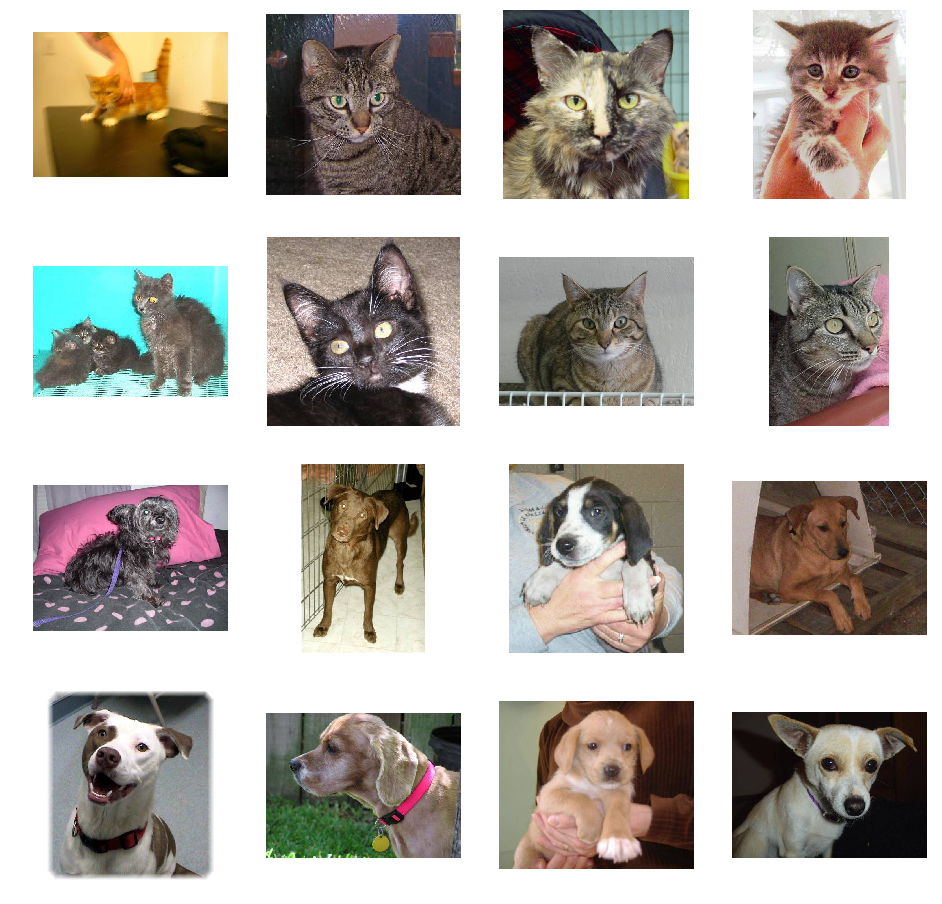

In [0]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Problem 1

Do feature extraction with data augmentation.


### Feature extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. We will use data augmentation. We will not use dropout.

### Build network with VGG16 convolution base and custom densely connected layers later  in VGG19


In [0]:
# Load the convolutional base
conv_base = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

# Freeze the convolutional base
conv_base.trainable = False

# Concatenate the convolutional base and densely connected layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# no dropout
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### Train the model end to end with frozen convolutional base

In [0]:
# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 30s 298ms/step - loss: 0.5901 - acc: 0.6840 - val_loss: 0.4552 - val_acc: 0.8050
Epoch 2/20
100/100 [==============================] - 25s 252ms/step - loss: 0.4908 - acc: 0.7770 - val_loss: 0.3779 - val_acc: 0.8380
Epoch 3/20
100/100 [==============================] - 25s 254ms/step - loss: 0.4284 - acc: 0.8025 - val_loss: 0.3463 - val_acc: 0.8530
Epoch 4/20
100/100 [==============================] - 25s 254ms/step - loss: 0.3964 - acc: 0.8305 - val_loss: 0.3196 - val_acc: 0.8620
Epoch 5/20
100/100 [==============================] - 25s 255ms/step - loss: 0.3880 - acc: 0.8345 - val_loss: 0.3070 - val_acc: 0.8690
Epoch 6/20
100/100 [==============================] - 25s 255ms/step - loss: 0.3688 - acc: 0.8365 - val_loss: 0.2975 - val_acc: 0.8630
Epoch 7/20
100/100 [==============================] - 25s 

### Display curves of loss and accuracy during training

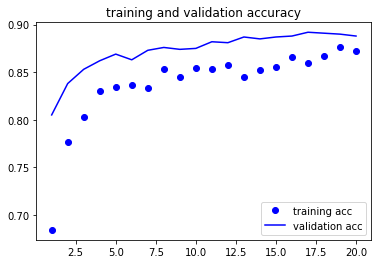

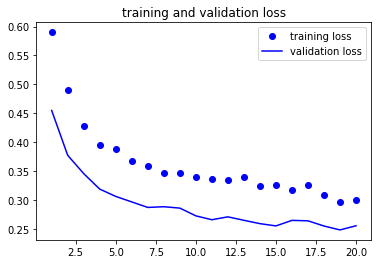

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

### Testing feature_extractio_data_augmentation

In [0]:
model,history= feature_extractio_data_augmentation(train_dir,validation_dir,epochs=30,lr=1e-5,batch_size=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 28s 278ms/step - loss: 0.6370 - acc: 0.6470 - val_loss: 0.5458 - val_acc: 0.7690
Epoch 2/30
100/100 [===============

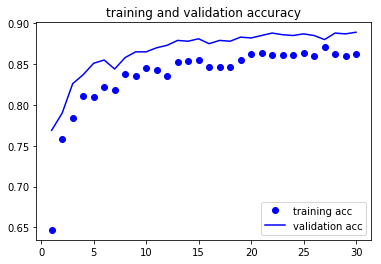

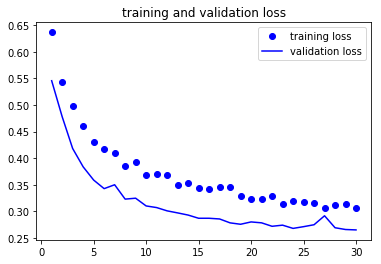

In [0]:
model_plot(history)

In [0]:
model_fname = 'cats_and_dogs_p1.h5' 
model.save(model_fname)


In [0]:
with open(model_fname, 'r') as f:
  files.download(model_fname)

### Problem 1  Solution with vgg16

In [75]:
model,history= feature_extractio_data_augmentation_full(train_dir,validation_dir,epochs=30,lr=1e-5,batch_size=20)

Layer num     Layer name    Trainable?
0             input_5       False
1             block1_conv1  False
2             block1_conv2  False
3             block1_pool   False
4             block2_conv1  False
5             block2_conv2  False
6             block2_pool   False
7             block3_conv1  False
8             block3_conv2  False
9             block3_conv3  False
10            block3_pool   False
11            block4_conv1  False
12            block4_conv2  False
13            block4_conv3  False
14            block4_pool   False
15            block5_conv1  False
16            block5_conv2  False
17            block5_conv3  False
18            block5_pool   False
19            flatten_4     True
20            dense_8       True
21            dense_9       True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
__________________

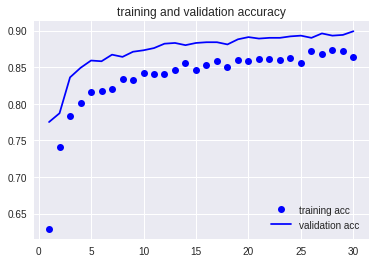

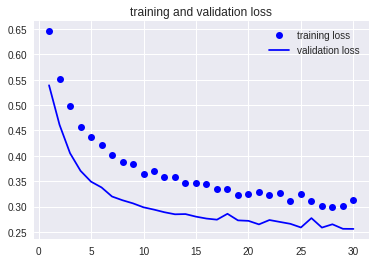

In [0]:
model_plot(history)


In [0]:
model_fname = 'cats_and_dogs_p1.h5' 
model.save(model_fname)

In [0]:
with open(model_fname, 'r') as f:
  files.download(model_fname)

## Problem 1 Final Solution  vgg19

In [16]:
model,history= feature_extractio_data_augmentation_fullvgg19(train_dir,validation_dir,epochs=30,lr=1e-5,batch_size=20)

80142336/80134624 [==============================] - 1s 0us/step
Layer num     Layer name    Trainable?
0             input_2       False
1             block1_conv1  False
2             block1_conv2  False
3             block1_pool   False
4             block2_conv1  False
5             block2_conv2  False
6             block2_pool   False
7             block3_conv1  False
8             block3_conv2  False
9             block3_conv3  False
10            block3_conv4  False
11            block3_pool   False
12            block4_conv1  False
13            block4_conv2  False
14            block4_conv3  False
15            block4_conv4  False
16            block4_pool   False
17            block5_conv1  False
18            block5_conv2  False
19            block5_conv3  False
20            block5_conv4  False
21            block5_pool   False
22            flatten_1     True
23            dense_2       True
24            dense_3       True
_________________________________________________

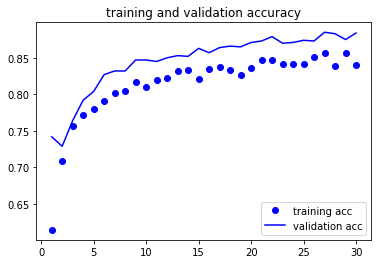

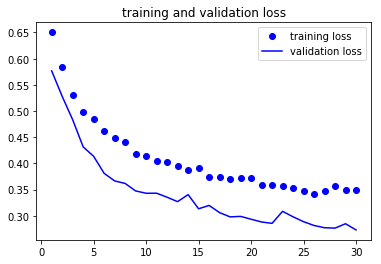

In [17]:
model_plot(history)

In [0]:
model_fname = 'cats_and_dogs_p1vgg19.h5' 
model.save(model_fname)


In [0]:
with open(model_fname, 'r') as f:
  files.download(model_fname)

## Problem 2

Do fine-tuning with data augmentation. 

### Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 28s 277ms/step - loss: 0.3041 - acc: 0.8710 - val_loss: 0.2808 - val_acc: 0.8900
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3034 - acc: 0.8616

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 58460, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

100/100 [==============================] - 25s 255ms/step - loss: 0.3034 - acc: 0.8620 - val_loss: 0.2586 - val_acc: 0.8850
Epoch 3/10
100/100 [==============================] - 25s 254ms/step - loss: 0.3149 - acc: 0.8680 - val_loss: 0.2554 - val_acc: 0.8810
Epoch 4/10
100/100 [==============================] - 25s 254ms/step - loss: 0.2992 - acc: 0.8670 - val_loss: 0.2494 - val_acc: 0.9000
Epoch 5/10
100/100 [==============================] - 25s 254ms/step - loss: 0.3050 - acc: 0.8670 - val_loss: 0.2843 - val_acc: 0.8760
Epoch 6/10
100/100 [==============================] - 25s 254ms/step - loss: 0.2967 - acc: 0.8735 - val_loss: 0.2442 - val_acc: 0.9050
Epoch 7/10
100/100 [==============================] - 25s 254ms/step - loss: 0.2964 - acc: 0.8720 - val_loss: 0.2749 - val_acc: 0.8900
Epoch 8/10
100/100 [==============================] - 25s 254ms/step - loss: 0.2976 - acc: 0.8705 - val_loss: 0.2726 - val_acc: 0.8820
Epoch 9/10
100/100 [==============================] - 25s 255ms/st

### Display learning curves during fine-tuning

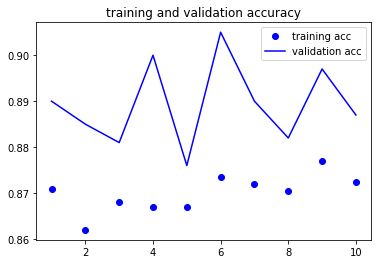

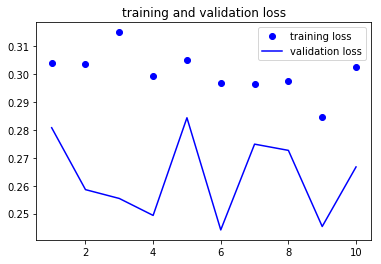

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

###  Problem 2 Testing training all the layers, all layers trainable (get the highest acc but is slower)

In [0]:
model,history= fine_tuning_data_augmentation(train_dir,validation_dir,epochs=30,lr=1e-5,batch_size=20,model_fname= 'cats_and_dogs_p1.h5' )

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 47s 470ms/step - loss: 0.3032 - acc: 0.8700 - val_loss: 0.1927 - val_acc: 0.9230
Epoch 2/30
100/100 [=======================

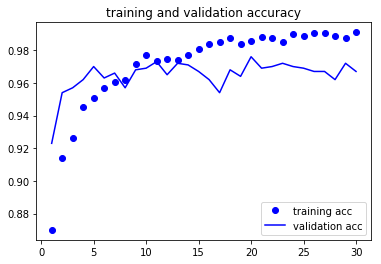

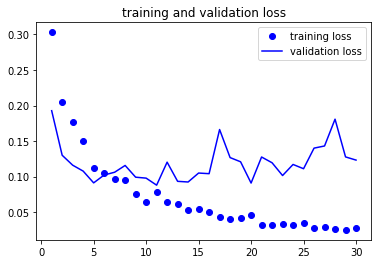

In [0]:
model_plot(history)

In [0]:
model_fname = 'cats_and_dogs_p2.h5' 
model.save(model_fname)

In [0]:
with open(model_fname, 'r') as f:
  files.download(model_fname)

### Problem 2  Solution for vgg16

In [0]:
model,history= fine_tuning_data_augmentation_full(train_dir,validation_dir,epochs=30,lr=1e-5,batch_size=20,model_fname= 'cats_and_dogs_p1.h5' )

****************Previus model all vgg layer freeze********************
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block

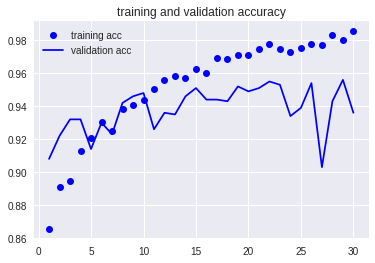

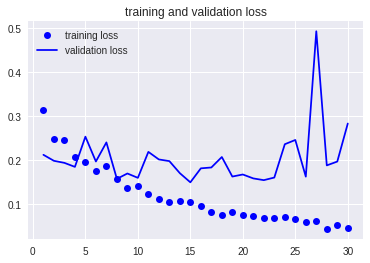

In [0]:
model_plot(history)

In [0]:
model_fname = 'cats_and_dogs_p2a.h5' 
model.save(model_fname)

In [0]:
with open(model_fname, 'r') as f:
  files.download(model_fname)

## Problem 2 Final Solution  vgg19

In [21]:
model,history= fine_tuning_data_augmentation_fullvgg19(train_dir,validation_dir,epochs=30,lr=1e-5,batch_size=20,model_fname= 'cats_and_dogs_p1vgg19.h5' )

****************Previus model all vgg layer freeze********************
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block

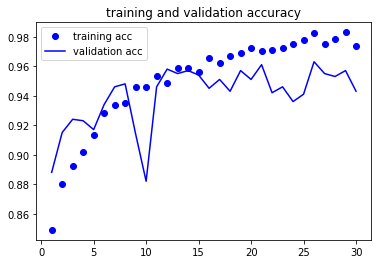

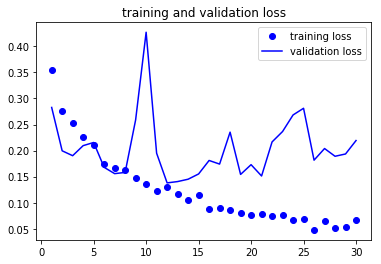

In [24]:
model_plot(history)

In [0]:
model_fname = 'cats_and_dogs_p2avgg19.h5' 
model.save(model_fname)

In [0]:
with open(model_fname, 'r') as f:
  files.download(model_fname)

## Problem 3

Visualize heatmaps of class activation for the the model obtained in Problem 2.


In [61]:
model = load_model('cats_and_dogs_p2avgg19.h5')
model.load_weights('cats_and_dogs_p2avgg19.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [69]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
images, labels = next(validation_generator)


Found 1000 images belonging to 2 classes.


In [70]:
x = np.expand_dims(images[1,:], axis=0)
model.predict(x)

array([[0.9999994]], dtype=float32)

In [71]:
model.predict(images)

array([[2.0861626e-07],
       [9.9999940e-01],
       [3.9293516e-01],
       [1.9341707e-05],
       [1.2534857e-04],
       [2.0861626e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.7492294e-02],
       [1.0000000e+00],
       [9.5276088e-02],
       [2.3841858e-07],
       [1.0000000e+00],
       [2.0591021e-03],
       [1.0123944e-01],
       [1.0000000e+00],
       [9.9999893e-01],
       [1.6689301e-06],
       [4.6908855e-05],
       [7.8219175e-04]], dtype=float32)

In [0]:
def process_image(img):
    last_conv_layer = model.get_layer('block5_conv4')
    #last_conv_layer = model.get_layer('block4_conv3')
    grads = K.gradients(model.output[0], last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0], model.output[0]])
    
    x = np.expand_dims(img, axis=0)
    pooled_grads_value, conv_layer_output_value, pred_value = iterate([x])
    
    if pred_value[0] < 1.0:
      if pred_value[0] < 0.5:
          conv_layer_output_value = 1-conv_layer_output_value 
      for i in range(512):
          conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    # normalize
    heatmap = (heatmap - heatmap.min())/(heatmap.max()-heatmap.min())
    
    heatmap_adj = cv2.resize(1-heatmap, (img.shape[1], img.shape[0]))
    heatmap_adj = np.uint8(255 * heatmap_adj)
    heatmap_adj = cv2.applyColorMap(heatmap_adj, cv2.COLORMAP_JET)
    
    superimposed_img = np.uint8(heatmap_adj * 0.4 + np.uint8(255 * img) * 0.6)
    
    return superimposed_img, pred_value[0],heatmap_adj

In [73]:
# only rescale for validation set
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
images, labels = next(validation_generator)


Found 1000 images belonging to 2 classes.


In [74]:
images.shape

(20, 150, 150, 3)

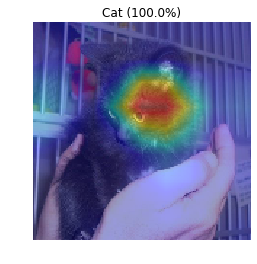

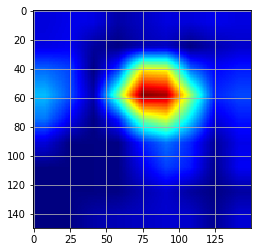

In [52]:
superimposed_img, pred,heatmap = process_image(images[1,:])
plt.imshow(superimposed_img)
if pred < 0.5:
  class_name = "Cat"
  pred = 1-pred
else:
  class_name = "Dog"
plt.title("{} ({:.1f}%)".format(class_name, pred*100))
plt.axis('off')

plt.grid(None)
plt.show()


plt.imshow(heatmap)
plt.grid(None)
plt.show()

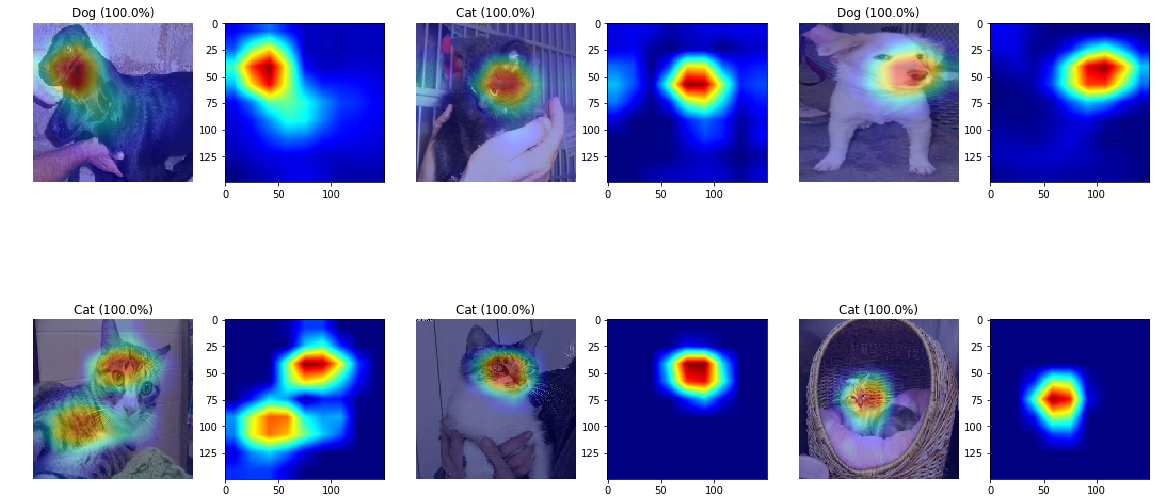

In [53]:
fig = plt.figure(figsize=(20, 10))
j=1
for i,img in enumerate(images[:6]):
    superimposed_img, pred,heatmap = process_image(img)
    plt.subplot(2, 6, j)
    plt.imshow(superimposed_img)
  
    if pred < 0.5:
        class_name = "Cat"
        pred = 1-pred
    else:
      class_name = "Dog"
        
    plt.title("{} ({:.1f}%)".format(class_name, pred*100))
    plt.axis('off')
    
    plt.subplot(2, 6, j+1)
    plt.imshow(heatmap)
    
    j=j+2;
plt.show()

## Problem 3 Final Solution

Found 1000 images belonging to 2 classes.


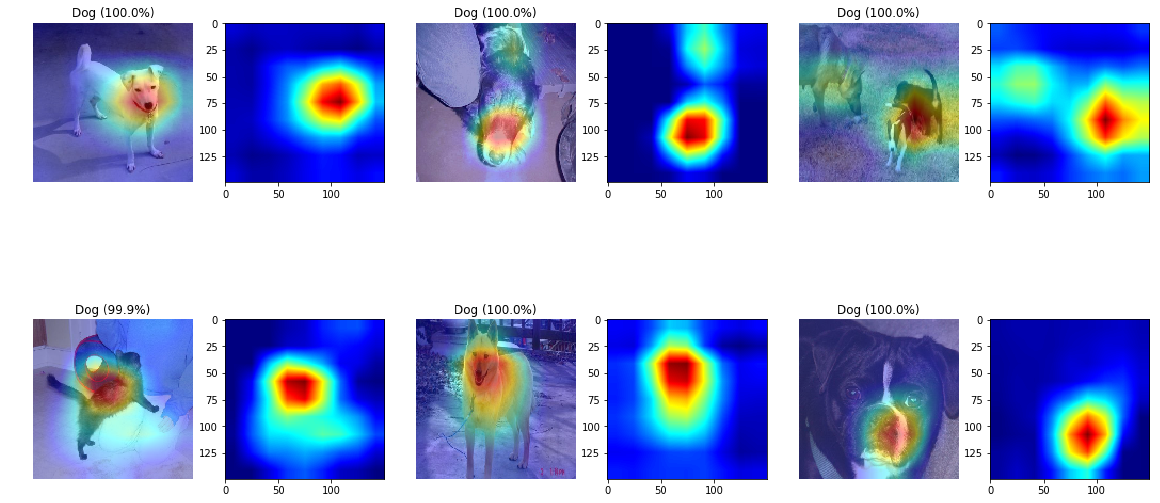

In [54]:
plot_heatmaps(validation_dir,num_imgs=6)

## Problem 4

Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.

In [34]:
model = load_model('cats_and_dogs_p2avgg19.h5')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
layer = model.get_layer('dense_6')
layer_output = layer.output

### Build Activation Model

In [0]:
activation_model = models.Model(inputs=model.input, outputs=[layer_output])


In [37]:
import numpy as np
# only rescale for validation set
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=1000,
    class_mode='binary')
images, labels = next(validation_generator)
print(images.shape)
print(labels.shape)

Found 1000 images belonging to 2 classes.
(1000, 150, 150, 3)
(1000,)


In [38]:
activations = activation_model.predict(images)
print(activations.shape)

(1000, 256)


### Visualization of the feature vectors produce by the convnet


In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        #txt = ax.text(x_coord, y_coord, str(idx), fontsize=16)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

### t-SNE Visualization of Activations

The goal is to take a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane. The algorithm is non-linear and adapts to the underlying data, performing different transformations on different regions.
[link text](https://)

In [40]:
time_start = time.time()

cat_dogs_tsne = TSNE(random_state=42).fit_transform(activations)

print('cat_dogs_tsne t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

cat_dogs_tsne t-SNE done! Time elapsed: 7.689817190170288 seconds


In [41]:
class_names = ["Cat", "Dog"]
print(class_names)

['Cat', 'Dog']


### t-SNE from activations (separates the data well)


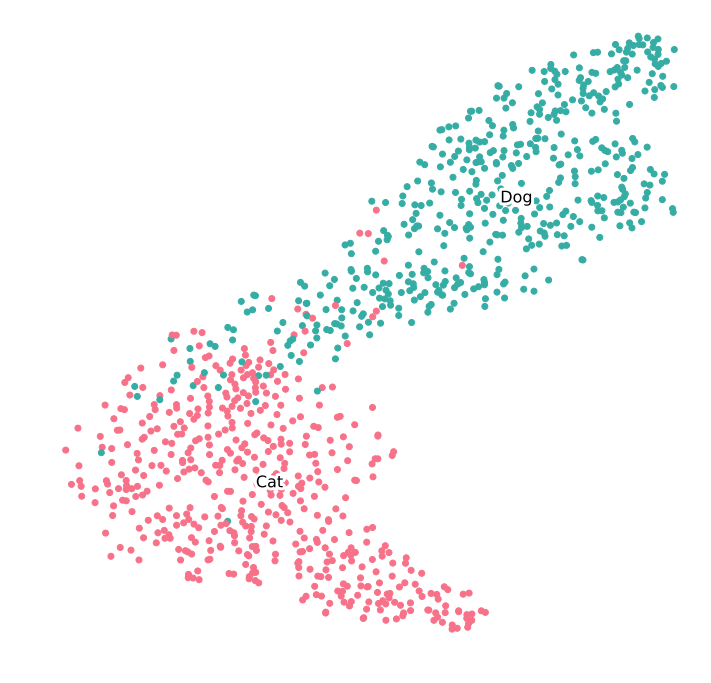

In [42]:
data_scatter(cat_dogs_tsne, labels)


###  t-SNE from input Images (separates the data bad)


In [43]:
time_start = time.time()


cat_dogs_tsne_input = TSNE(random_state=42).fit_transform(np.reshape(images,(1000,150*150*3)))

print('Input cat_dogs_tsne t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

Input cat_dogs_tsne t-SNE done! Time elapsed: 178.05377912521362 seconds


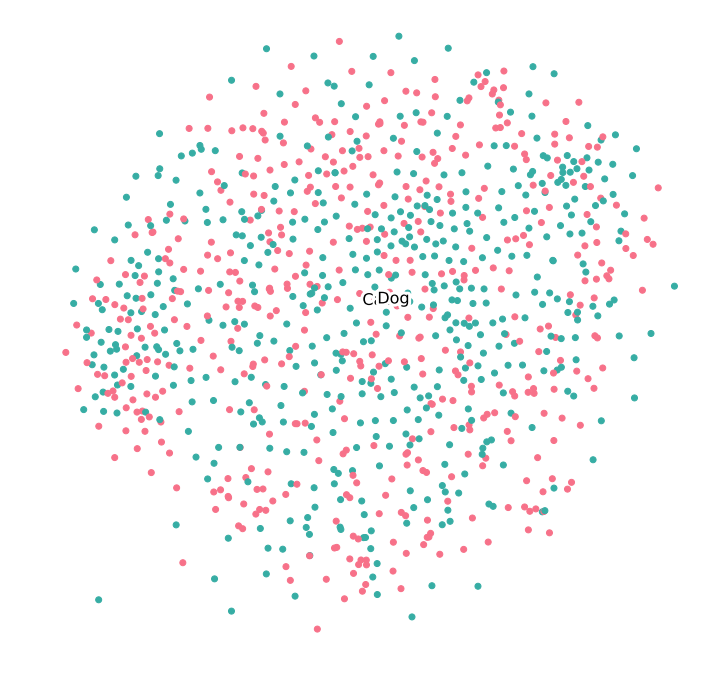

In [45]:
data_scatter(cat_dogs_tsne_input, labels)

*** We can see how  t-SNE from activations performs better than t-SNE direct from input Images. After applying t-SNE visualization to these activations we can see how well the convnet separates cats from dogs, we can clearly see 2 classes, but when applying t-SNE visualization to the input images the classes are not separated. ***

## Problem 4 Final Solution

***  Plot how output of dense layer(dense_6 ) and output of convnet (flatten_3) separates the data  ***

Found 1000 images belonging to 2 classes.


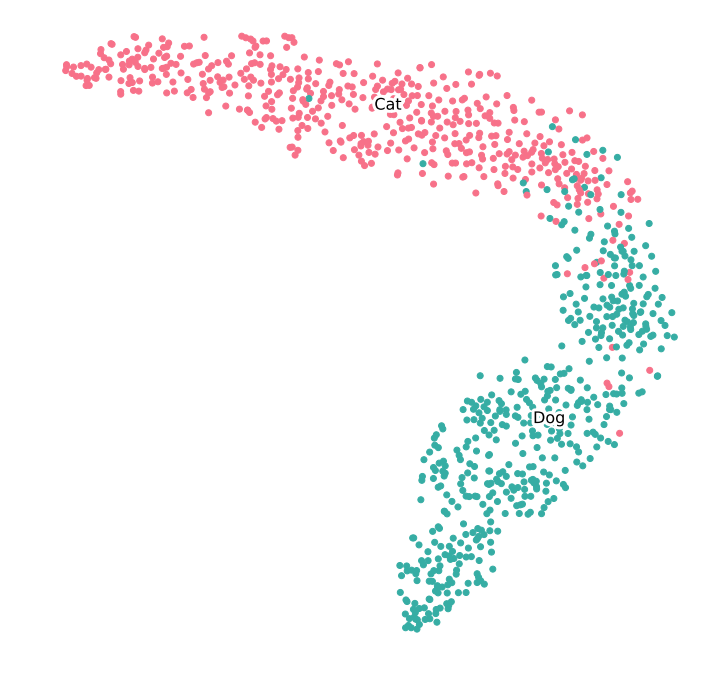

In [55]:
tSNE_visualization(validation_dir)

Applying  t-SNE visualization to the activations to see how well the convnet separates cats from dogs.

Found 1000 images belonging to 2 classes.


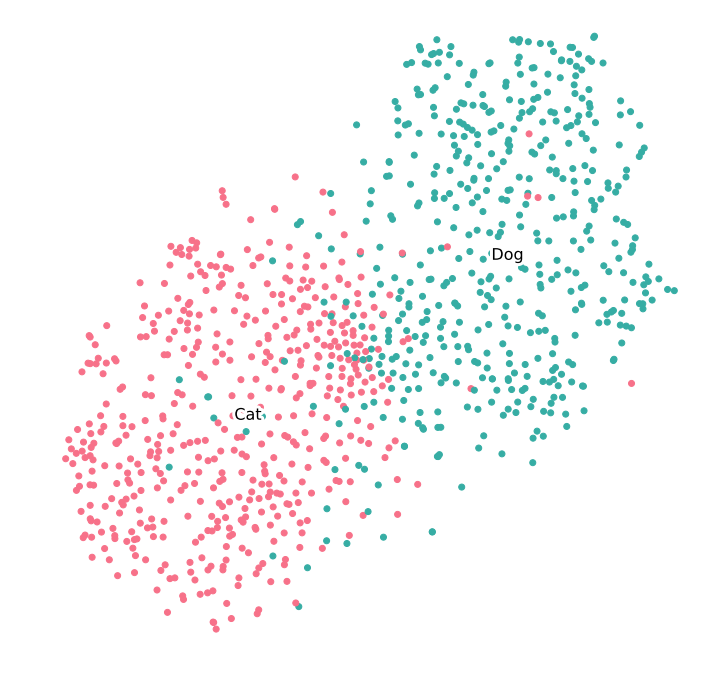

In [57]:
tSNE_visualization(validation_dir,model_name='cats_and_dogs_p2avgg19.h5',layer_name='flatten_3')